# Constructing Social Networks in the Bible

### <i>Lemuel Kumarga</i>


## Problem Description

Our social circles are huge parts of our lives. They represent who we interact with, and how much we interact with them. With the digitization of communication and socialization, finding out this circle within each individual is an easier task than before. A simple glimpse into social networking sites such as Facebook and LinkedIn allows us to see who our friends are, whilst the frequency of digital communication can be used as a proxy of our closeness with them.

However, such information was not easily quantifiable in the pre-technology era. By attempting to model past lives using modern concepts, we could potentially gain further information about the past. For this project, we will use Natural Language Processing (NLP) concepts to <b>construct a social network for the bible, with the aim to depeen our understanding of the gospel.</b>


## Preliminaries

First load the necessary modules for this exercise.

In [1]:
import sys
sys.path.append('shared/')
import defaults as _d

# Load All Main Modules
_d.load({"pd":"pandas",
         "math":"math",
         "cl":"collections",
         "np":"numpy",
         "sp":"scipy",
         "re":"re",
         "mpl":"matplotlib",
         "plotly":"plotly",
         "nltk":"nltk",
         "wordcloud":"wordcloud",
         "PIL":"PIL",
         "operator":"operator",
         "nx":"networkx"},
         globals())

# Load All Submodules
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import plotly.offline as py
import plotly.graph_objs as py_go

# If you can't find the module, run nltk.download() in python
from nltk import sent_tokenize, word_tokenize

_d.stylize()

We will also construct helper functions to be used later on.

In [2]:
# -------------------------------------
# Genre-Related Functions
# -------------------------------------
def __get_genre_groups():
    global _genre_group
    if "_genre_group" not in globals():
        _genre_group = bible.groupby("Genre",sort=False)
    return _genre_group

def __get_genre_colors():
    global _genre_colors
    if "_genre_colors" not in globals():
        color_pal = _d.get_color("palette")(len(__get_genre_groups()))
        color_dict = dict()
        ind = 0
        for name, _ in __get_genre_groups():
            color_dict[name] = color_pal[ind]
            ind += 1
        _genre_colors = color_dict
    return _genre_colors

def __get_genre_legends(rev = True):
    global _genre_legends
    global _genre_legends_rev
    if "_genre_legends" not in globals():
        _genre_legends = [mpatches.Patch(color=_d.bg_color,label="Genre")]
        for name, group in __get_genre_groups():
            legend_text = name + " (" + group.index[0]
            if (len(group.index) > 1):
                legend_text += " - " + group.index[-1]
            legend_text += ")"
            _genre_legends.append(mpatches.Patch(color=__get_genre_colors()[name], label=legend_text))
        _genre_legends_rev = _genre_legends[:0:-1]
        _genre_legends_rev.insert(0,_genre_legends[0])
    
    if rev:
        return _genre_legends_rev
    else:
        return _genre_legends

# -------------------------------------
# Word-Cloud Related Functions
# -------------------------------------
def __word_cloud(input, fig_size = (20,10), image = None, colors = None):
    
    # Step 1: If there is an image specified, we need to create a mask
    mask = None
    if (image != None):
        mask = np.array(PIL.Image.open(image))
        if (colors == "image_colors"):
            colors = wordcloud.ImageColorGenerator(mask)
    
    # Step 2: Set up default colors
    def_colors = mpl.colors.ListedColormap(_d.get_color())
    
    # Step 3: Generate Word Cloud
    #https://stackoverflow.com/questions/43043437/wordcloud-python-with-generate-from-frequencies
    wc = wordcloud.WordCloud(height=fig_size[1]*100,
                             width=fig_size[0]*100,
                             background_color=_d.bg_color,
                             mask = mask,
                             colormap = def_colors,
                             color_func = colors).generate_from_frequencies(input)

    # Step 4: Plot Word Cloud
    plt.figure(figsize=fig_size)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

__get_legend_separator = mpatches.Patch(color=_d.bg_color,label="")    
    
def __get_minmax_legends(input, title, key_format = "{:.2f}"):
    output = []
    output.append(mpatches.Patch(color=_d.bg_color,label=title))
    max_item = max(input.items(), key=operator.itemgetter(1))
    output.append(mlines.Line2D([0], [0], marker='o', color=_d.bg_color, label="Max: " + key_format.format(max_item[1]) + " - " + max_item[0],
                      markerfacecolor=_d.ltxt_color, markersize=20))
    min_item = min(input.items(), key=operator.itemgetter(1))
    output.append(mlines.Line2D([0], [0], marker='o', color=_d.bg_color, label="Min: " + key_format.format(min_item[1]) + " - " + min_item[0],
                      markerfacecolor=_d.ltxt_color, markersize=10))
    return output

__min_color = _d.pollute_color(_d.bg_color,_d.txt_color,0.4)
def __get_saturate_legends(title):
    output = []
    output.append(mpatches.Patch(color=_d.bg_color,label=title))
    output.append(mpatches.Patch(color=_d.get_color(0),label="Concentrated In 1 Genre"))
    output.append(mpatches.Patch(color=_d.pollute_color(__min_color,_d.get_color(0),0.3), label="Spread Out Across\nMultiple Genres"))
    return output
    

## Exploration

### Loading the Data

For this exercise, we will be using the bible <a data-toggle="popover" title="" data-content="A collection of texts" data-original-title="Corpus">corpus</a> from <a href="https://www.kaggle.com/oswinrh/bible/data" target="_blank">Kaggle.</a> The data will be stored in abbreviated book keys, with each book containing the following attributes:

* <span class="hl">Book Name</span>: Full name of the book
* <span class="hl">Testament</span>: New (NT) or old (OT)
* <span class="hl">Genre</span>: Genre of the book
* <span class="hl">Chapters</span>: Number of chapters
* <span class="hl">Verses</span>: Total number of verses
* <span class="hl">Text</span>: The actual text of the book



In [3]:
# Get all book statistics
abb = pd.read_csv("data/key_abbreviations_english.csv")\
        .query('p == 1')[["a","b"]]\
        .rename(columns={"a" : "Key"})
ot_nt = pd.read_csv("data/key_english.csv")\
          .rename(columns={"n" : "Name", "t" : "Testament"})
genres = pd.read_csv("data/key_genre_english.csv")\
           .rename(columns={"n" : "Genre"})

# Load the main biblical text
bible = pd.read_csv("data/t_asv.csv")\
          .groupby("b", as_index=False)\
          .agg({"c": pd.Series.nunique, "v": "size", "t":" ".join})\
          .rename(columns={"c": "Chapters","v": "Verses","t": "Text"})
# Perform some cleaning
bible['Text'] = bible['Text'].apply(lambda t: re.sub("[`']","",t))

# Join the remaining book statistics
bible = bible.join(abb.set_index('b'), on='b')\
             .join(ot_nt.set_index('b'), on='b')\
             .join(genres.set_index('g'), on='g')\
             .drop(['b', 'g'], axis=1)\
             .set_index('Key')\
             [["Name","Testament","Genre","Chapters","Verses","Text"]]
            
# Show the first few lines
bible.head(5)

,Name,Testament,Genre,Chapters,Verses,Text
Key,,,,,,
Gen,Genesis,OT,Law,50,1533,In the beginning God created the heavens and t...
Exo,Exodus,OT,Law,40,1213,"Now these are the names of the sons of Israel,..."
Lev,Leviticus,OT,Law,27,859,"And Jehovah called unto Moses, and spake unto ..."
Num,Numbers,OT,Law,36,1288,And Jehovah spake unto Moses in the wilderness...
Deut,Deuteronomy,OT,Law,34,959,These are the words which Moses spake unto all...



### About the Data

We will also derive some language statistics from each book, mainly:

* <span class="hl">Sentences</span>: Number of sentences in each book.
* <span class="hl">Words</span>: Number of words in each book.

In [4]:
# Add Sentences and Words columns
bible["Sentences"] = pd.Series(0, index=bible.index)
bible["Words"] = pd.Series(0, index=bible.index)

# Save Tokens
sent_tokens = OrderedDict()
word_tokens = OrderedDict()

for i, r in bible[["Text"]].iterrows():
    txt = r.str.cat()
    sent_tokens[i] = sent_tokenize(txt)
    word_tokens[i] = word_tokenize(txt)
    bible.at[i,'Sentences'] = len(sent_tokens[i])
    # Remove Punctuation
    bible.at[i,'Words'] = len([w for w in word_tokens[i] if re.match('\w+',w)])

# Show
bible[["Name","Testament","Genre","Chapters","Verses","Sentences","Words"]].head(5)

,Name,Testament,Genre,Chapters,Verses,Sentences,Words
Key,,,,,,,
Gen,Genesis,OT,Law,50,1533,1756,38097
Exo,Exodus,OT,Law,40,1213,1116,32177
Lev,Leviticus,OT,Law,27,859,664,23830
Num,Numbers,OT,Law,36,1288,996,32034
Deut,Deuteronomy,OT,Law,34,959,745,27952


#### Book Length

One of the most intuitive ways to understand the books' uneven distribution is to assume that we are doing devotions of each chapter a day. Under such a scenario, we will have the following timeline:   

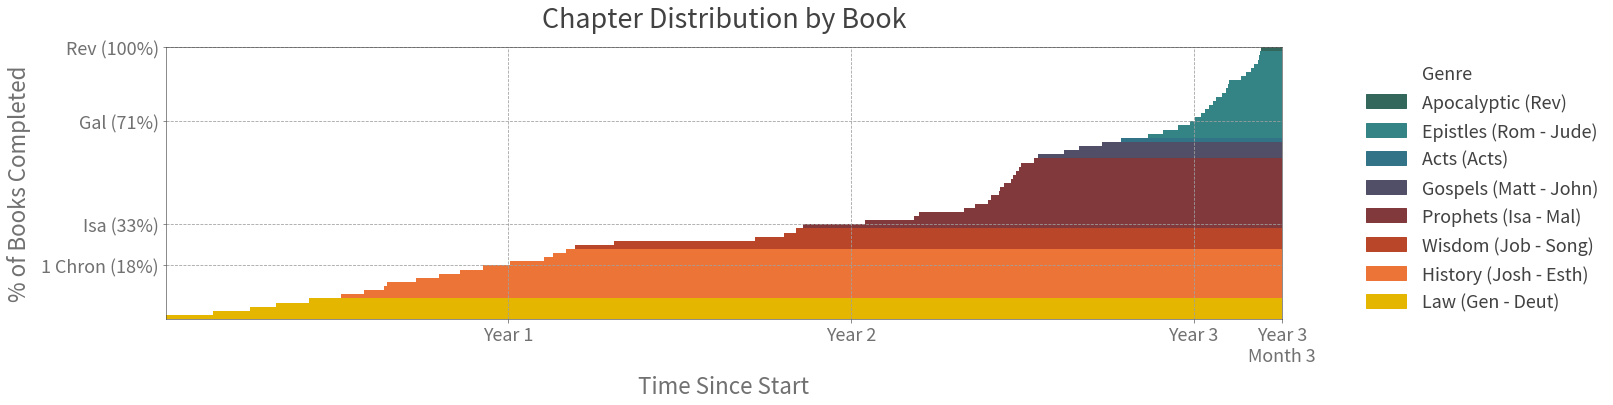

In [5]:
plt.figure(figsize=(20,5))
    
# Create Plots
yticks = []
ylabels = []
x_progress = 0
x_length = sum(bible["Chapters"])
y_progress = 0
y_length = len(bible["Chapters"])               
for name, group in __get_genre_groups():

    row_ids = [ bible.index.get_loc(i) for i in group.index ]

    # Part 1: Bars When Genre Is Still Being Read
    length = 0
    # For each book in the genre
    for idx in row_ids:

        # If we are reading this book in the anniversary 
        if (math.floor((x_progress + length)/365) < math.floor((x_progress + length + bible["Chapters"][idx])/365)):
            yticks.append(idx + 1)
            ylabels.append("{} ({}%)".format(bible.index[idx],round(idx/y_length * 100)))

        plt.broken_barh([(x_progress + length, bible["Chapters"][idx])],
                        (y_progress, (idx + 1) - y_progress),
                        facecolors = __get_genre_colors()[name])
        length += bible["Chapters"][idx]
    
    
    # Part 2: Bars When Genre has Been Read
    plt.broken_barh([(x_progress + length, x_length - x_progress - length)],
                    (y_progress, max(row_ids) + 1 - y_progress), 
                    facecolors = __get_genre_colors()[name])
    
    x_progress += length
    y_progress = max(row_ids) + 1
    

# Add Titles and Grid
plt.title("Chapter Distribution by Book")
plt.grid(color=_d.fade_color(_d.ltxt_color,0.5), linestyle='dashed')

# Add X-Axis Details
plt.xlabel("Time Since Start")
xticks = [365, 2 * 365, 3 * 365 ,sum(bible["Chapters"])]
xlabels = [ "Year 1", "Year 2", "Year 3", "Year 3\nMonth 3" ]
plt.xticks(xticks, xlabels)
plt.xlim(0,x_length)

# Add Y-Axis Details
yticks.append(y_length)
ylabels.append("{} ({}%)".format(bible.index[-1],round(1 * 100)))
plt.ylabel("% of Books Completed")
plt.yticks(yticks, ylabels)
plt.ylim(0, y_length)

# Add Legends
plt.legend(handles=__get_genre_legends(), bbox_to_anchor=[1.3, 1.0])

plt.show()

By the 1st year, we will have only completed 18% of the books on the bible. If this is not discouraging enough, after a further year, we would still not have completed the Old Testament (<span class="yellow-text">Law</span> to <span class="red-text">Prophets</span>). However, upon reaching the New Testament (<span class="blue-text">Gospels</span> to <span class="green-text">Apocalyptic</span>), we could complete the whole set of books within 9 months. The Old Testament is at least 3 times longer than the New Testament!

####  Chapter Length

Assuming that the average human reads <a href="http://www.readingsoft.com/" target="_blank">200 words per minute</a>, we can also estimate how long it will take to read 1 chapter every day:

In [6]:
bible["Minutes_p_Chapter"] = bible["Words"] / bible["Chapters"] / 200.
inputs = []

deg_incr = 360. / len(bible.index)
for name, group in __get_genre_groups():
    
    # Insert Legend Item
    inputs.append(
        py_go.Scatterpolar(
            r = [0, 0, 0, 0],
            theta = [0, 0, 0, 0],
            name = name,
            legendgroup = name,
            mode = 'none',
            fill = 'toself',
            fillcolor = __get_genre_colors()[name],
            showlegend = True
        )
    
    )    
    
    # Insert Each Book
    for key, val in group["Minutes_p_Chapter"].items():
        inputs.append(
            py_go.Scatterpolar(
                r = [0, val, val, 0],
                theta = [0,bible.index.get_loc(key)*deg_incr,(bible.index.get_loc(key)+1)*deg_incr,0],
                name = bible["Name"][key],
                legendgroup = name,
                mode = 'none',
                hoverinfo ='text',
                text=bible["Name"][key] + ": " + "{:.1f}".format(val) + " min",
                fill = 'toself',
                fillcolor = __get_genre_colors()[name],
                showlegend = False
            )
        )


layout = py_go.Layout(_d.py_layout)
layout["autosize"] = False
layout["width"] = 450
layout["height"] = 350
layout["margin"] = dict(t=80,l=0,r=0,b=20)
layout["title"] = "Minutes Required to Read a Chapter"
layout["polar"]["angularaxis"]["visible"]=False

fig = py_go.Figure(data=inputs, layout=layout)
py.iplot(fig)

From the chart above, we conclude that chapter lengths across books are varied as well. For example, a chapter in <span class="hl orange-text">1 Kings</span> will take around 5.5 minutes to read, whilst a chapter in <span class="hl red-text">Psalms</span> will take around 1.5 minutes to read. 

### Preliminary Insights

After obtaining an overview of the bible as a text, we will proceed to investigate the occurences of various characters in the bible.

#### The Trinity

The first point of interest is how much God appears at different book in the bible:


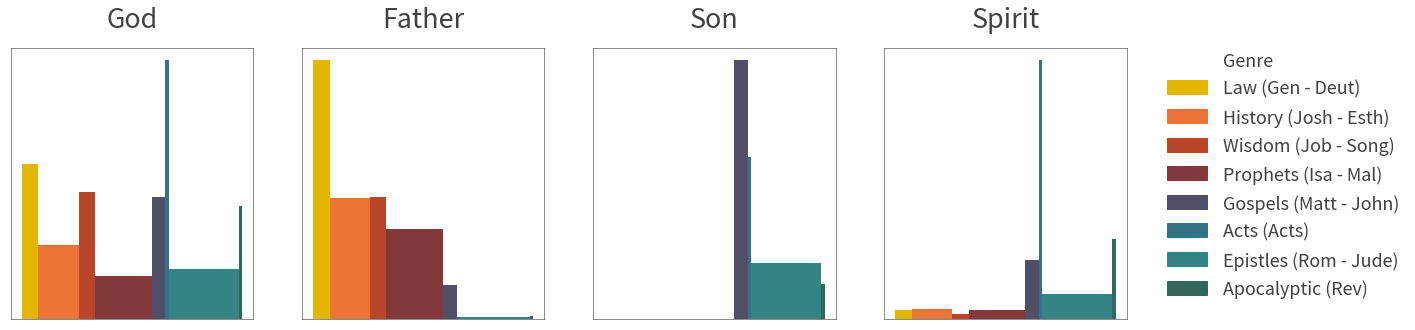

In [7]:
def find_occurence(regex):
    output = OrderedDict()
    for name, group in __get_genre_groups():
        l = [len(re.findall(regex,wt.str.cat())) for _, wt in group[["Text"]].iterrows()]
        output[name] = (len(l),sum(l)/len(l))
    return output

entityToSearch = OrderedDict([('God', 'God|Lord|GOD|LORD'),
                              ('Father','Jehovah|Father'),
                              ('Son','Jesus|Christ|Emmanuel'),
                              ('Spirit','Spirit')])

ind = 0
# Construct Plots for Each Entity
f, splt = plt.subplots(1,len(entityToSearch.items()), figsize=(20,5))
for title, regex in entityToSearch.items():
    occurences = find_occurence(regex)
    splt[ind].set_title(title)
    splt[ind].set_xticks([])
    splt[ind].set_yticks([])
    x = 0
    for n, v in occurences.items():
        splt[ind].bar([x + v[0]/2],
                      [v[1]],
                      color = __get_genre_colors()[n],
                      width = v[0])
        x += v[0]
    ind += 1

# Insert Legends
plt.legend(handles=__get_genre_legends(False), bbox_to_anchor = [2.2, 1.05])

plt.show()

Unsurprisingly, words associated with God the Father (Jehovah/Father) appears prominently in the Old Testament, while words associated with God the Son (Jesus/Christ) hits a high frequency in the Gospel narratives. Word counts of the Spirit appears the highest in Acts. This sequence is in line with the story of the Gospel, where the events first transcribed were between God the Father and His people, followed by Jesus Christ and his believers, and finally with the Holy Spirit and the church.

(Note: The limitation of such an approach is the failure to capture regular words meant to symbolize God. For example, words such as "Lamb" in Revelations correspond to Christ, but such symbols were excluded as they would introduce false positives.)

#### Major Characters

Using <a href="http://bibleblender.com/2014/biblical-lessons/biblical-history/complete-list-of-major-minor-characters-in-bible" target="_blank">external sources</a>, we can also obtain a list of the major characters in the bible. This list can then be used as a reference to detect names within the bible:

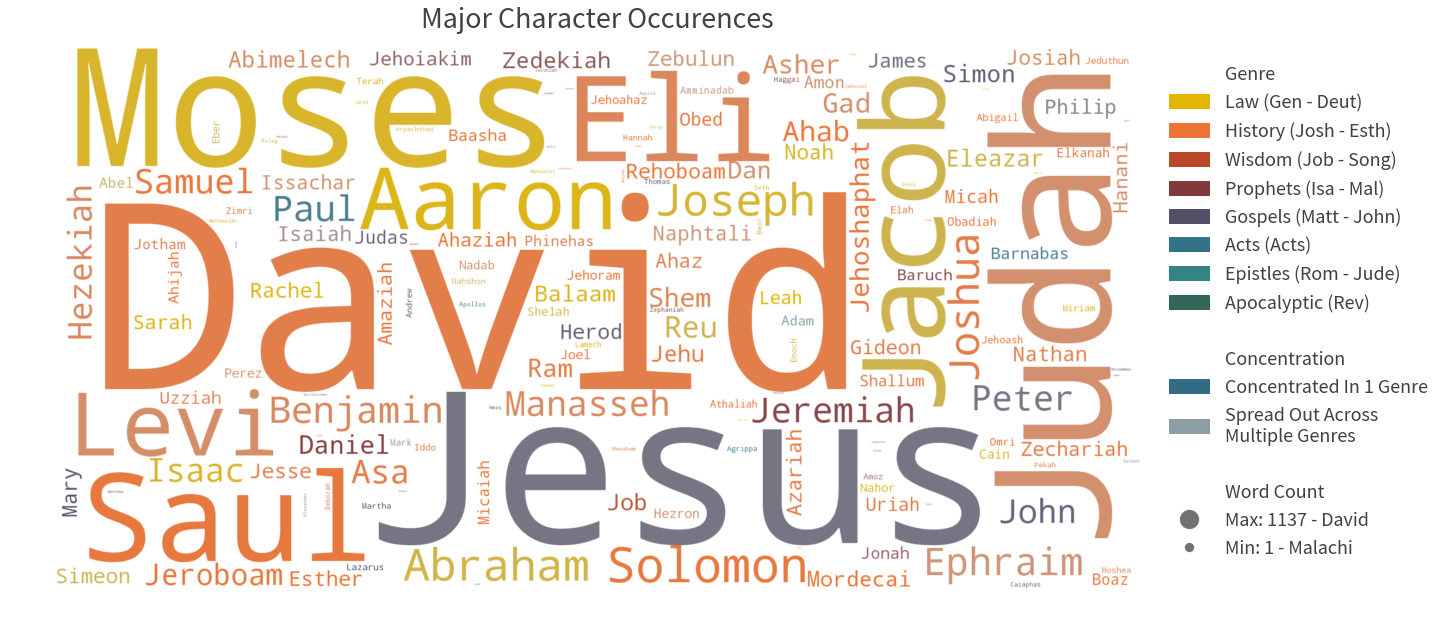

In [8]:
# Characters obtained from http://bibleblender.com/2014/biblical-lessons/biblical-history/complete-list-of-major-minor-characters-in-bible
characters_regex = 'Adam|Seth|Enos|Kenan|Mahalalel|Jared|Enoch|Methuselah|Lamech|Noah|Shem|Adam|Cain|Enoch|Irad|Mehujael|Methusael|Lamech|Tubal-cain|Arpachshad|Shelah|Eber|Peleg|Reu|Serug|Nahor|Terah|Abraham|Isaac|Jacob|Judah|Perez|Hezron|Ram|Amminadab|Nahshon|Salmon|Boaz|Obed|Jesse|David|Abel|Kenan|Enoch|Noah |Abraham|Isaac|Jacob|Joseph|Sarah|Rebecca|Rachel|Leah|Moses|Aaron|Miriam|Eldad|Medad|Phinehas|Joshua|Deborah|Gideon|Eli|Elkanah|Hannah|Abigail|Samuel|Gad|Nathan|David|Solomon|Jeduthun|Ahijah|Elijah|Elisha|Shemaiah|Iddo|Hanani|Jehu|Micaiah|Jahaziel|Eliezer|Zechariah|Huldah|Isaiah|Jeremiah|Ezekiel|Daniel|Hosea|Joel|Amos|Obadiah|Jonah|Micah|Nahum|Habakkuk|Zephaniah|Haggai|Zechariah|Malachi|Beor|Balaam|Job|Amoz|Beeri|Baruch|Agur|Uriah|Buzi|Mordecai|Esther|Oded|Azariah|Abimelech|Saul|Ish-boseth|David|Solomon|Jeroboam|Nadab|Baasha|Elah|Zimri|Tibni|Omri|Ahab|Ahaziah|Jehoram|Jehu|Jehoahaz|Jehoash|Jeroboam|Zechariah|Shallum|Menahem|Pekahiah|Pekah|Hoshea|Rehoboam|Abijam|Asa|Jehoshaphat|Jehoram|Ahaziah|Athaliah|Jehoash|Amaziah|Uzziah|Jotham|Ahaz|Hezekiah|Manasseh|Amon|Josiah|Jehoahaz|Jehoiakim|Jeconiah|Zedekiah|Simon|John|Aristobulus|Alexander|Hyrcanus|Aristobulus|Antigonus|Herod|Herod|Herod|Philip|Salome|Agrippa|Agrippa|Simon|Aaron|Eleazar|Eli|Phinehas|Asher|Benjamin|Dan|Gad|Issachar|Joseph|Ephraim|Manasseh|Judah|Levi|Naphtali|Reuben|Simeon|Zebulun|Jesus|Mary|Joseph|James|Jude|Joses|Simon|Peter|Andrew|James|John|Philip|Bartholomew|Thomas|Matthew|James|Judas|Simon|Judas|Matthias|Paul|Barnabas|James|Jude|Caiaphas|Annas|Zechariah|Agabus|Anna|Simeon|John|Apollos|Aquila|Dionysius|Epaphras|Joseph|Lazarus|Luke|Mark|Martha|Mary|Mary|Nicodemus|Onesimus|Philemon'
character_freq = []
for name, group in __get_genre_groups():
    names = [re.findall(characters_regex,wt.str.cat()) for _, wt in group[["Text"]].iterrows()]
    l = [(w,name) for l in names for w in l]
    character_freq.extend(l)

# The frequency of each character occurence by genre
character_freq = nltk.ConditionalFreqDist(character_freq)

# Create color functions to determine the genre most associated with the character
def color_func(word, font_size, position, orientation, **kwargs):
    most_common_genre = character_freq[word].most_common(1)[0][0]
    intensity = 1. * character_freq[word][most_common_genre] / sum(character_freq[word].values())
    return _d.pollute_color(__min_color, __get_genre_colors()[most_common_genre],intensity)

# Plot word cloud for each name
inputs = {}
for n, fd in character_freq.items():
    inputs[n] = sum(fd.values())
__word_cloud(inputs, colors=color_func)

# Titles
plt.title("Major Character Occurences")

# Legends
legend_cloud = list(__get_genre_legends(False))
legend_cloud.append(__get_legend_separator)
legend_cloud.extend(__get_saturate_legends("Concentration"))
legend_cloud.append(__get_legend_separator)
legend_cloud.extend(__get_minmax_legends(inputs, "Word Count","{:d}"))
plt.legend(handles=legend_cloud, bbox_to_anchor = [1.28, 1.])
plt.show()



Based on the list, we conclude that <span class="hl orange-text">David</span> appears the most in the bible. In addition, his appearances seem to be concentrated within the <span class="hl orange-text">History</span> genre. This is in stark-contrast to <span class="hl">Jesus</span>, whose name appeared across multiple genres (in particular across the New Testament).

(Note: One limitation of this approach is the assumption that there is a 1-1 mapping for most names to the person. To improve the accuracy of the results, we would need to perform some name disambiguation - i.e. Does Saul refer to King Saul or Paul aka Saul? Does John refer to the disciple or the Baptist?. Unfortunately, such analysis are not within the scope of this project.) 

## Preparation

In order to construct a social network, we first need to identify the relevant entities in the bible. One approach is to find a list of characters from external sources, and then using that list to identify the entity. However, this method is <span class="hl">unscalable</span>. To illustrate this, suppose that we would like to construct a similar network for "Oliver Twist". Then, we would need to find a list of names associated with the book. But what happens if we are not able to find such a list? The project would come to a dead end.

As such, to reduce reliance on external sources, we need to develop a more robust approach in identifying the relevant characters in the bible.

### Finding the Entities

Fortunately, we are able to capture names due to the nature of English linguistics. Names fall under the category of "Proper Nouns", which we can detect using <a href="https://en.wikipedia.org/wiki/Part-of-speech_tagging" target="_blank">Part-of-Speech (POS) tagging</a>:


In [9]:
tagged_word_tokens = OrderedDict((n, nltk.tag.pos_tag(wt)) for n, wt in word_tokens.items())
# Extract Only Proper Nouns and Add Index
proper_noun_tokens = OrderedDict((n, [(i, w[0]) for i, w in enumerate(wt) if w[1] == "NNP"]) for n, wt in tagged_word_tokens.items())
# Print 100 Most Common Words
noun_freq = nltk.FreqDist(w for n,wt in proper_noun_tokens.items() for i, w in wt)
", ".join([n for n, v in noun_freq.most_common(50)])

'Jehovah, God, Israel, Lord, David, O, Jesus, Judah, Jerusalem, Thou, Moses, Egypt, Behold, Christ, Saul, Jacob, Aaron, Spirit, Babylon, Solomon, Son, Father, Abraham, Joseph, Joshua, Pharaoh, Jordan, Levites, Go, Thy, Ye, Moab, Psalm, Benjamin, Ephraim, My, Holy, A, Paul, Jews, Peter, Yea, Zion, Manasseh, Samuel, Jeremiah, Joab, John, Hezekiah, Isaac'

Based on the above, we have captured a majority of names by tagging them under Proper Nouns. However, there are also some false positive words such as <span class="hl">O, Go, Thy, Ye</span> that have to be removed. It is also interesting to see entities other than people, for example, <span class="hl">Jerusalem, Babylon</span> represent countries. In the next section, we will determine how to handle each case.

### Managing the Cases

The first case to handle is the occurence of words which are not proper nouns (<span class="hl">O, Go, Thy, Ye</span>). To solve this, we simply need to exclude such words from consideration:


In [10]:
false_npp = ['O','Thou','Behold','Go','Thy','Ye','My','A','Yea','Thus','Come',
             'Therefore','Wherefore','Be','So','Hear','ye','Psalm','Selah','Arise','Woe','King','Speak',
             'Almighty','Who','How','Chief','thy','Fear','Musician','Which','High','Take','Most',
             'Shall','Lo','Let','Praise','Make','Nay','Say','River','Art','Amen','South','Lest',
             'Bring','Oh','Remember','Did','Teacher','Sea','Whosoever','Do','Every','Unto','Know',
             'Are','Mine','See','Tell','Whoso','Gods','Wilt','Red','Holy','[',']','Mount', 'TR','Please',
             'Tent','Man','Passover','Meeting','Will','Again','Whoever','Savior','Ai','No','May','Heaven',
             'Whose']
# Extract Only Proper Nouns and Add Index
proper_noun_tokens = OrderedDict((n, [(i, w) for i, w in wt if w not in false_npp]) for n, wt in proper_noun_tokens.items())
# Print 100 Most Common Words after excluding False Proper Nouns
noun_freq = nltk.FreqDist(w for n,wt in proper_noun_tokens.items() for i, w in wt)
", ".join([n for n, v in noun_freq.most_common(100)])

'Jehovah, God, Israel, Lord, David, Jesus, Judah, Jerusalem, Moses, Egypt, Christ, Saul, Jacob, Aaron, Spirit, Babylon, Solomon, Son, Father, Abraham, Joseph, Joshua, Pharaoh, Jordan, Levites, Moab, Benjamin, Ephraim, Paul, Jews, Peter, Zion, Manasseh, Samuel, Jeremiah, Joab, John, Hezekiah, Isaac, Assyria, Samaria, Jonathan, Jehovahs, Ammon, Absalom, Gentiles, Jeroboam, Gilead, Elijah, Philistines, Canaan, Edom, Ahab, Daniel, Esau, Jehoshaphat, Pharisees, Levi, Reuben, Hebron, Simon, Lebanon, Syria, Galilee, Dan, Gad, Beth-el, Shechem, Abimelech, Eleazar, Jericho, Baal, Zedekiah, Sheol, Balaam, Bashan, Abner, Damascus, Asa, Jehu, Tyre, Job, Elisha, Mordecai, Noah, Josiah, Pilate, Nebuchadnezzar, Mary, Abram, Naphtali, Jehoiada, Satan, Isaiah, Haman, Davids, Esther, Azariah, Sodom, Pharaohs'

The second case to consider is non-human entities. Some examples of these are nations (<span class="hl">Jerusalem, Babylon</span>), locations (<span class="hl">Galilee</span>) and false idols (<span class="hl">Baal</span>). Since the relationships between non-human entities can also yield useful insights, we will not be excluding such words.

The third case is symbols referencing to an entity (<span class="hl">Lord, Father, Son</span>). We will be including such words as well for the same reason as the second case.

### The Entity Cloud

Using the <span class="hl">Proper Noun</span> approach, we can subsequently plot these entities into a word cloud:

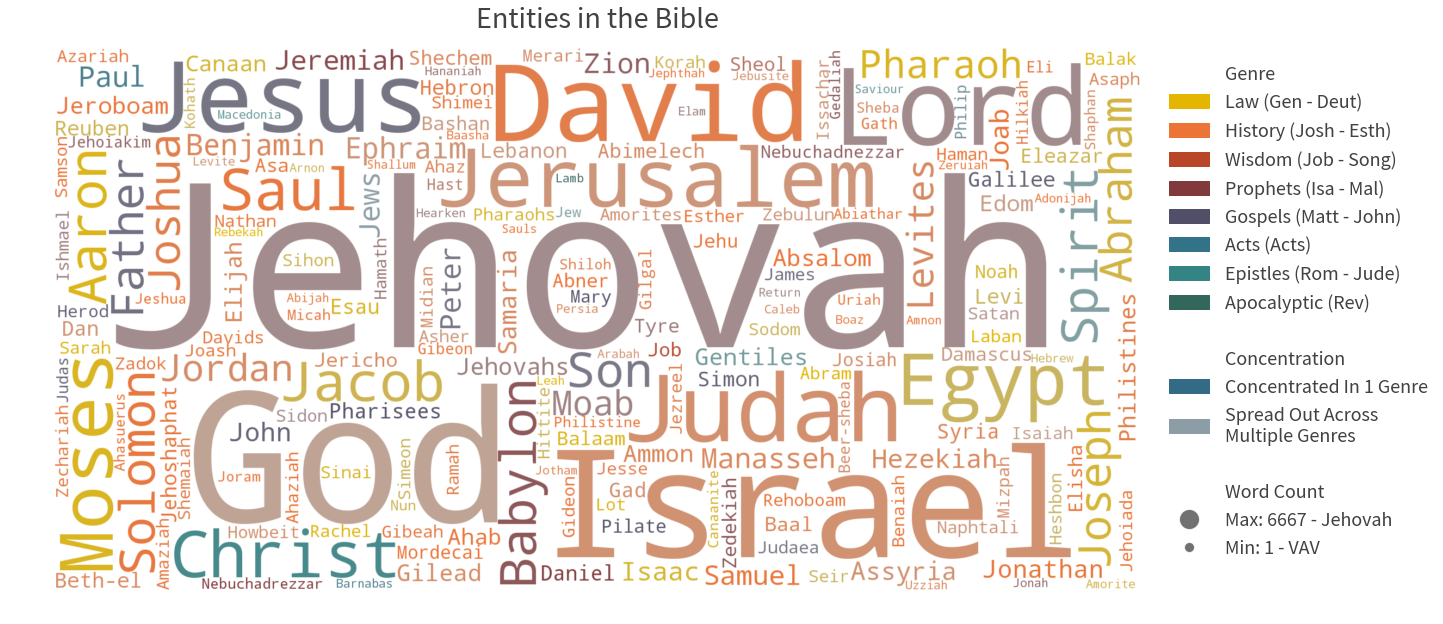

In [11]:
# The frequency of each character occurence by genre
character_freq = nltk.ConditionalFreqDist((w[1],bible["Genre"][n]) for n,wt in proper_noun_tokens.items() for w in wt)

# Create color functions to determine the genre most associated with the character
def color_func(word, font_size, position, orientation, **kwargs):
    most_common_genre = character_freq[word].most_common(1)[0][0]
    intensity = 1. * character_freq[word][most_common_genre] / sum(character_freq[word].values())
    return _d.pollute_color(__min_color, __get_genre_colors()[most_common_genre],intensity)

# Plot word cloud for each name
inputs = {}
for n, fd in character_freq.items():
    inputs[n] = sum(fd.values())
__word_cloud(inputs, colors=color_func)

# Titles
plt.title("Entities in the Bible")

# Legends
legend_cloud = list(__get_genre_legends(False))
legend_cloud.append(__get_legend_separator)
legend_cloud.extend(__get_saturate_legends("Concentration"))
legend_cloud.append(__get_legend_separator)
legend_cloud.extend(__get_minmax_legends(inputs, "Word Count","{:d}"))
plt.legend(handles=legend_cloud, bbox_to_anchor = [1.28, 1.])
plt.show()

As can be seen, we have now expanded the word cloud of major characters (<span class="orange-text">David</span>, <span class="purple-text">Jesus</span>) into a larger entity of names, nations, symbols (amongst others). There are also some interesting patterns starting to emerge. For once, the word <span class="purple-text hl">Jesus</span> is dispersed across multiple genres, while the word <span class="cyan-text hl">Christ</span> is concentrated within the Epistles!

## Constructing the Network

Now that we have obtained the list of entities in the bible, we can begin constructing the network.

### Vertices and Edges

The first step is to determine the units of the network. Entities can be defined as vertices. 

For simplicity, we assume that the closeness of names within the text are proxies to the entities' degree of intimacy. The number of words between entities can then be used as the weight of the edges.

In [12]:
vertices = inputs
edges = {}
edges_count = {}

# Construction parameters
dist_l = 50
decay = 1.

# Loop Through Each Book
for k, l in proper_noun_tokens.items():
    # Loop Through Each Entity
    for i in range(len(l)):
        ind, ent = l[i]
        # On a fixed entity, compare with neighboring entities
        for i_hat in range(i+1, min(i+1+dist_l, len(l))):
            ind_hat, ent_hat = l[i_hat]
            # If proximity is pretty close, consider that an edge
            if (abs(ind - ind_hat) <= dist_l and ent != ent_hat):
                k = tuple(sorted([ent, ent_hat]))
                if (k not in edges):
                    edges_count[k] = 1
                    edges[k] = np.exp(-1. * decay * abs(ind - ind_hat))
                else:
                    edges_count[k] += 1
                    edges[k] += np.exp(-1. * decay * abs(ind - ind_hat))


### The Social Network

After obtaining the list of vertices and edges, we are now ready to construct the graph.


In [56]:
# Construct the Graph
G = nx.Graph()
G.add_nodes_from(w for w,_ in vertices.items())
G.add_weighted_edges_from((k[0], k[1], v) for k, v in edges.items())

# For illustrative purposes, let us show only the top 50 entities
n_show = 50
sorted_vertices = sorted(vertices.items(), key=operator.itemgetter(1), reverse = True)
sub_G = G.subgraph(n for n, _ in sorted_vertices[:n_show])

############################### Plotly Construction ##############################
pos = nx.spring_layout(sub_G, k=2.0)


############################### Prepare Elements ##############################
# Construct Vertices for Plotly
v_plotly = {}
for node in sub_G.nodes():
    v_plotly[node] = {
        "x": pos[node][0],
        "y": pos[node][1],
        "size": min(vertices[node] / 500. * 30.,30),
        "color": _d.fade_color(_d.txt_color,0.3),
        "rank": 9999 # To determine which color to be plotted
    }

e_plotly = {}
# Rank each edge based on their weight
sorted_edges = sorted(edges.items(), key=operator.itemgetter(1), reverse=True)
rankings = {}
for i in range(len(sorted_edges)):
    k, _ = sorted_edges[i]
    
    if (k[0] not in rankings):
        rankings[k[0]] = {
            k[1]: i + 1
        }
    else:
        rankings[k[0]][k[1]] = i + 1
    
    if (k[1] not in rankings):
        rankings[k[1]] = {
            k[0]: i + 1
        }
    else:
        rankings[k[1]][k[0]] = i + 1

# Construct Edges for Plotly
for edge in sub_G.edges():
    
    # Get Rankings and Update Vertices Accordingly
    rank = rankings[edge[0]][edge[1]]
    v_plotly[edge[0]]["rank"] = min(rank, v_plotly[edge[0]]["rank"])
    v_plotly[edge[1]]["rank"] = min(rank, v_plotly[edge[1]]["rank"])
    
    # Positions
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    
    # Line Colors and Line Width
    weight = sub_G[edge[0]][edge[1]]['weight']
    
    # Colors and Thickness of Line is Dependent on the Rank
    if rank < 5:
        color = _d.get_color(0)
        linew = 5.
    elif rank <= 50:
        if rank <= 10:
            low_b = 10
            upp_b = 5
            col_ind = 1
            fade_factor = 0.8
        elif rank <= 30:
            low_b = 30
            upp_b = 11
            col_ind = 2
            fade_factor = 0.5
        elif rank <= 50:
            low_b = 50
            upp_b = 31
            col_ind = 3
            fade_factor = 0.3
        
        min_w = sorted_edges[low_b-1][1]
        max_w = sorted_edges[upp_b-1][1]
        color = _d.fade_color(_d.get_color(col_ind),fade_factor)
        linew = 1. + (weight - min_w) / (max_w - min_w) * 2.
    else:
        max_w = sorted_edges[50][1]
        color = (_d.txt_color + ("%02x" % int(weight / (max_w * 2.) * 255)))
        linew = 0.5
    
    e_plotly[edge[0] + "-" + edge[1]] = {
        "nodes" : [edge[0], edge[1]],
        "x": [x0, x1],
        "y": [y0, y1],
        "color": color,
        "linewidth": linew,
        "rank": rank
    }

# Update Vertices Color Based on Ranking
for k, v in v_plotly.items():
    if v["rank"] < 5:
        v["color"] = _d.get_color(0)
    elif v["rank"] <= 10:
        v["color"] = _d.get_color(1)
    elif v["rank"] <= 30:
        v["color"] = _d.get_color(2)
    elif v["rank"] <= 50:
        v["color"] = _d.get_color(3)

############################### Draw Elements ##############################
# Create Elements For Plotly
data = []

# Edges First So That Vertices Are In Front of Nodes
for k,v in e_plotly.items():
    data.append(py_go.Scatter(
        x=v["x"],
        y=v["y"],
        text=" <-> ".join(v["nodes"]),
        line=py_go.Line(
            width=v["linewidth"],
            color=v["color"]
        ),
        hoverinfo="none",
        mode="lines"
    ))

# Vertices Next
data.append(py_go.Scatter(
    x=[v["x"] for _,v in v_plotly.items()],
    y=[v["y"] for _,v in v_plotly.items()],
    text=[k for k in v_plotly.keys()],
    mode='markers+text',
    hoverinfo='text',
    marker=py_go.Marker(
        color=[v["color"] for _,v in v_plotly.items()],
        size=[v["size"] for _,v in v_plotly.items()]),
    textposition='bottom'
))

layout = py_go.Layout(_d.py_layout)
layout["title"] = "Social Network of Top 50 Entities in The Bible"
layout["hovermode"]='closest'
layout["showlegend"] = False
layout["xaxis"] = py_go.XAxis(showgrid=False, zeroline=False, showticklabels=False)
layout["yaxis"] = py_go.YAxis(showgrid=False, zeroline=False, showticklabels=False)
fig = py_go.Figure(data=data,layout=layout)

py.iplot(fig)


### Network Slices

## Summary of Results

In [14]:
_d.__color_palette

['#336b87', '#34675c', '#a43820', '#683b52', '#34888c']

In [15]:
_d.__css_vars["--color-1"]

'#336b87'

In [16]:
_d.__css_vars

{'--blue': '#336b87',
 '--code-family': ('Share Tech Mono', 'monospace'),
 '--color-1': '#336b87',
 '--color-2': '#34675c',
 '--color-3': '#a43820',
 '--color-4': '#683b52',
 '--color-5': '#34888c',
 '--cyan': '#34888c',
 '--defined': "yes'",
 '--font-color': '#424242',
 '--font-color-50': '#42424280',
 '--font-color-75': '#424242bf',
 '--font-family': ('Source Sans Pro', 'sans-serif'),
 '--green': '#34675c',
 '--heading-color': '#154376',
 '--heading-color-50': '#15437680',
 '--heading-color-75': '#154376bf',
 '--heading-family': ('Titillium Web', 'sans-serif'),
 '--orange': '#ee693f',
 '--pri': '#ffffff',
 '--pri-50': '#ffffff80',
 '--pri-75': '#ffffffbf',
 '--purple': '#683b52',
 '--red': '#a43820',
 '--sec': '#304a68',
 '--sec-50': '#304a6880',
 '--sec-75': '#304a68bf',
 '--yellow': '#e4b600'}